Load all the pre required packages to run the code.

In [ ]:
import matplotlib
from matplotlib import pylab as plt
import nibabel as nib
from nibabel import nifti1
from nibabel.viewers import OrthoSlicer3D
import numpy as np
import cv2 as cv
import os
from scipy import ndimage
import os 
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D,concatenate
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow.keras.utils
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import glob
import scipy.io
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

This cell contains

*   The code for pre-processing the images
*   The code for the model 
*   The code for all the evaluation metrics.
*   The function result_refine is used to post process the predictions

Code refernce from 
1.   https://github.com/edwinpalegre/EE8204-ResUNet/blob/master/model_resunet.py
2.   https://github.com/nikhilroxtomar/Deep-Residual-Unet/

In [ ]:
import cv2
def pre_process(img):
    img = img
    img[img > 100] = 100
    img[img < -1000] = -1000
    min_perc, max_perc = np.percentile(img, 5), np.percentile(img, 95)
    img_valid = img[(img > min_perc) & (img < max_perc)]
    mean, std = img_valid.mean(), img_valid.std()
    img = (img-mean)/std
    return img
def conv_2d(inp, filters, kernel=(3, 3), padding="same", strides=1):
    conv2d =BatchNormalization()(inp)
    conv2d=Activation('relu')(conv2d)
    conv2d = Conv2D(filters, kernel, padding=padding, strides=strides)(conv2d)
    return conv2d
def skip_connections(inp, filters, kernel=(1, 1), padding="same", strides=1):
  skip = Conv2D(filters, kernel_size=kernel, padding=padding, strides=strides)(inp)
  skip =BatchNormalization()(skip)
  return skip
def stem(inp, filters, kernel=(3, 3), padding="same", strides=1):
    conv2d = Conv2D(filters, kernel, padding=padding, strides=strides)(inp)
    conv2d = conv_2d(conv2d, filters, kernel=kernel, padding=padding, strides=strides)
    skip=skip_connections(inp,filters,strides=strides)
    output = Add()([conv2d, skip])
    return output

def res_block(inp, filters, kernel=(3, 3), padding="same", strides=1):
    res = conv_2d(inp, filters, kernel=kernel, padding=padding, strides=strides)
    res = conv_2d(res, filters, kernel=kernel, padding=padding, strides=1)
    skip=skip_connections(inp,filters,strides=strides)
    output = Add()([skip, res])
    return output

def decoder_upsample(x, xskip,n):
    #u =UpSampling2D((2, 2))(x)
    u=Conv2DTranspose(n, (3, 3), strides=(2, 2), padding="same")(x)
    c = Concatenate()([u, xskip])
    dec=res_block(c,n)
    return dec

def DRSegUNet(n):
     #start neurons
    inputs =Input((512, 512, 1))
    #stem
    inp = inputs
    stem_ = stem(inp, n*1)
    #encoder
    enc1 = res_block(stem_, n*2, strides=2)
    enc2 = res_block(enc1, n*4, strides=2)
    enc3 = res_block(enc2, n*8, strides=2)
    enc4 = res_block(enc3, n*16, strides=2)
    #Bridge
    bri = conv_2d(enc4, n*16, strides=1)
    bri1 = conv_2d(bri, n*16, strides=1)
    #Decoder
    up1 = decoder_upsample(bri1, enc3,n*16)
    up2 = decoder_upsample(up1, enc2,n*8)
    up3 = decoder_upsample(up2, enc1,n*4) 
    up4 = decoder_upsample(up3, stem_,n*2)  
    outputs = Conv2D(4, (1, 1), padding="same", activation="softmax")(up4)
    model = Model(inputs, outputs)
    return model
def iou(true_y, pred_y):
    def f(true_y, pred_y):
        intersection = (true_y * pred_y).sum()
        union = true_y.sum() + pred_y.sum() - intersection
        x = (intersection)/(union)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [true_y, pred_y], tf.float32)

def dice_coef(y_true, y_pred):
    smooth = 1e-7
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +smooth)

def recall_(y_true, y_pred):
    true_p = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_p = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    return true_p / (predicted_p + K.epsilon())
def precision_(y_true, y_pred):
    true_p = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_p = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    return true_p / (predicted_p + K.epsilon())

def f1_score(y_true, y_pred):
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon())) 
def plot_hists(images):
    plt.hist(images.ravel(), bins=100, density=True, color='b', alpha=1)
def result_refine(img):
    print(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[3]):
            for k in range(img.shape[1]):
               for l in range(img.shape[2]):
                    img[i,k,l,j] = 1 if (img[i,k,l,j] > 0.5) else 0;
    return img

To train the model on MedSeg dataset run the set of cells from here or move further down to run on Radiopedia dataset.



*   Load the MedSeg data set 
*   Pre process the images
*   Split the images to train and testing files
*   Call the model compile and train
To load the data upload it to the runtime in google colab system, if it is in your google drive use google mount and add the path to the data file please add the path in the place of "images_medseg.npy" and "masks_medseg.npy"





In [ ]:
path='/content/drive/MyDrive/data for dissertation/'

In [ ]:

ct=np.load(path+"images_medseg.npy").astype('float32')
mask=np.load(path+"masks_medseg.npy").astype('float32')
ct= pre_process(ct)
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(ct, mask, test_size=0.2, random_state=42)
model=DRSegUNet(16)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.000098), metrics=["acc", iou,f1_score,dice_coef])
#model.summary()
results = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=38, batch_size=1, verbose=1)

  


Epoch 1/38
80/80 [==============================] - 28s 83ms/step - loss: 0.7208 - acc: 0.7494 - iou: 0.4921 - f1_score: 0.7217 - dice_coef: 0.6371 - val_loss: 0.7885 - val_acc: 0.7183 - val_iou: 0.4023 - val_f1_score: 0.7168 - val_dice_coef: 0.5700
Epoch 2/38
80/80 [==============================] - 6s 74ms/step - loss: 0.3276 - acc: 0.8884 - iou: 0.7021 - f1_score: 0.8889 - dice_coef: 0.8225 - val_loss: 0.8682 - val_acc: 0.7186 - val_iou: 0.5592 - val_f1_score: 0.7191 - val_dice_coef: 0.7063
Epoch 3/38
80/80 [==============================] - 6s 74ms/step - loss: 0.2622 - acc: 0.9114 - iou: 0.7591 - f1_score: 0.9116 - dice_coef: 0.8606 - val_loss: 0.7166 - val_acc: 0.7371 - val_iou: 0.6184 - val_f1_score: 0.7387 - val_dice_coef: 0.7531
Epoch 4/38
80/80 [==============================] - 6s 74ms/step - loss: 0.2261 - acc: 0.9233 - iou: 0.7833 - f1_score: 0.9234 - dice_coef: 0.8767 - val_loss: 0.7125 - val_acc: 0.7932 - val_iou: 0.6535 - val_f1_score: 0.7927 - val_dice_coef: 0.7804
Epo

This block of code is to predict the segmentation masks from trained model.

*   You can change the val_x to train_x to predict on training set or just use val_x to predict on validation set
*   result_refine funtion transforms all the probabilites into labels



(20, 512, 512, 4)


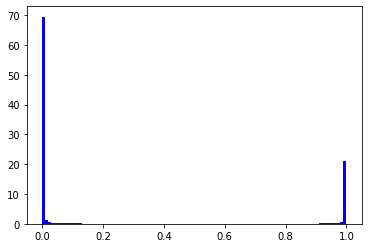

<Figure size 432x288 with 0 Axes>

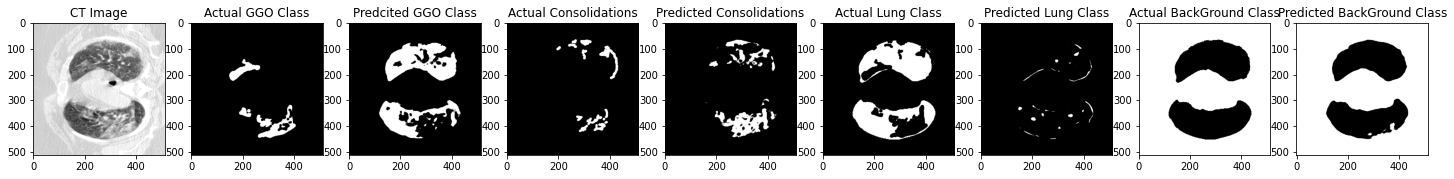

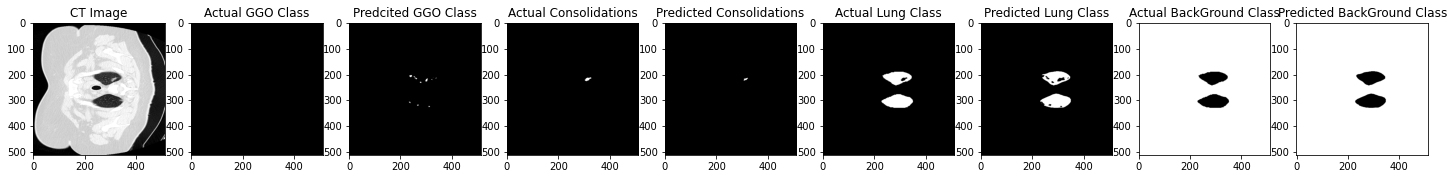

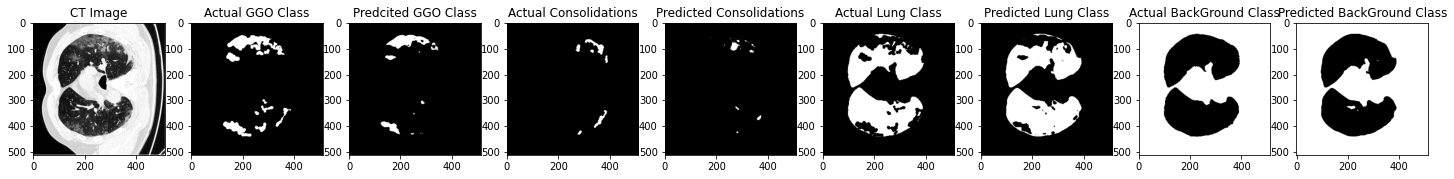

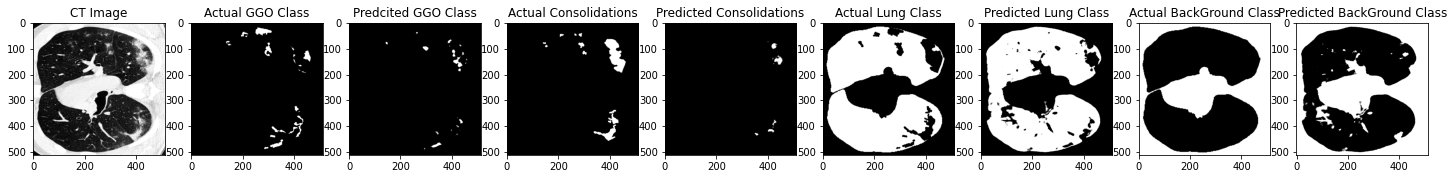

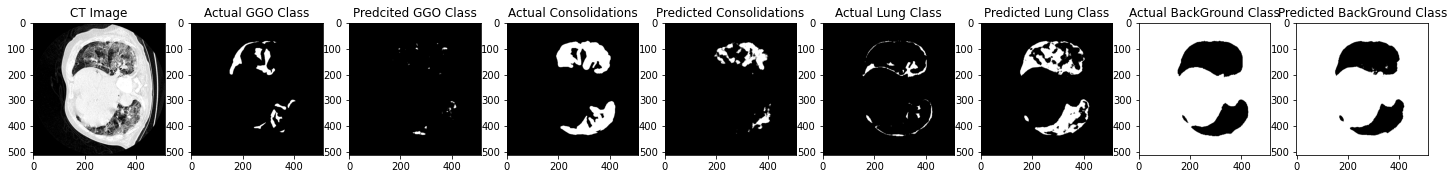

In [ ]:
pred= model.predict(val_x,batch_size=1) 
def plot_hists(images):
    plt.hist(images.ravel(), bins=100, density=True, color='b', alpha=1)
plot_hists(pred)
p1=result_refine(pred)

for i in range(5, 10):
    plt.figure(i)
    fig, ax = plt.subplots(1,9, figsize=(25,25))
    ax[0].imshow(val_x[i].reshape(512,512),cmap='gray')
    ax[0].title.set_text("CT Image")
    ax[1].imshow(val_y[i,:,:,0],cmap='gray')
    ax[1].title.set_text("Actual GGO Class")
    ax[2].imshow(p1[i,:,:,0],cmap='gray')
    ax[2].title.set_text("Predcited GGO Class")
    ax[3].imshow(val_y[i,:,:,1],cmap='gray')
    ax[3].title.set_text("Actual Consolidations")
    ax[4].imshow(p1[i,:,:,1],cmap='gray')
    ax[4].title.set_text("Predicted Consolidations")
    ax[5].imshow(val_y[i,:,:,2],cmap='gray')
    ax[5].title.set_text("Actual Lung Class")
    ax[6].imshow(p1[i,:,:,2],cmap='gray')
    ax[6].title.set_text("Predicted Lung Class")
    ax[7].imshow(val_y[i,:,:,3],cmap='gray')
    ax[7].title.set_text("Actual BackGround Class")
    ax[8].imshow(p1[i,:,:,3],cmap='gray')
    ax[8].title.set_text("Predicted BackGround Class")

The next two cells were used for extarcting results to add into the report. To run these change 

pred=model(val_x,batch_size=1) to pred= model(ct,batch_size=1)

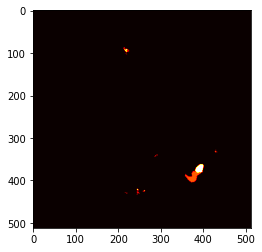

In [ ]:
x=p1[10,:,:,1]
y=p1[10,:,:,0]
x[x==1]=2
y=y+x
from matplotlib import colors
plt.imshow(y,cmap='hot')


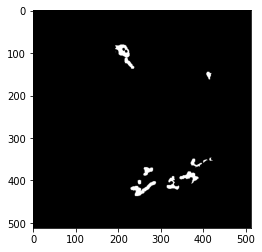

In [ ]:
plt.imshow(val_y[10,:,:,0],cmap='gray')

This cell is used to plot all the evaluation metrics of the trained model on MedSeg Dataset

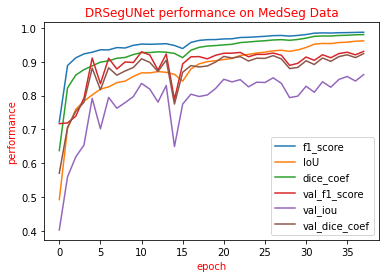

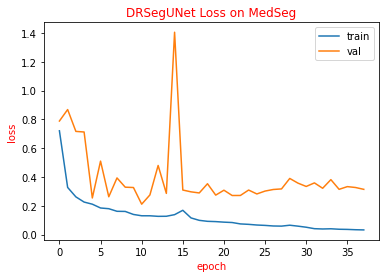

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(results.history["f1_score"])
plt.plot(results.history["iou"])
plt.plot(results.history["dice_coef"])
plt.plot(results.history["val_f1_score"])
plt.plot(results.history["val_iou"])
plt.plot(results.history["val_dice_coef"])
plt.title("DRSegUNet performance on MedSeg Data", color="red")

plt.xlabel("epoch", color="red")
plt.ylabel("performance", color="red")
plt.legend(["f1_score", "IoU",'dice_coef',"val_f1_score","val_iou","val_dice_coef"])
plt.show()

plt.figure(1)
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.title("DRSegUNet Loss on MedSeg", color="red")

plt.xlabel("epoch", color="red")
plt.ylabel("loss", color="red")
plt.legend(["train", "val"])
plt.show()

save the model.

In [ ]:
#model.save(path+"medSeg")

All the cells from here can be run to train the model on RadioPedia dataset, predict and visualise the results.



*   Load dataset, pre process, split into training and validation sets.
*   Compile and train the model
*   The output layer has to be changed as RadioPedia masks contain 3 channels which is performed in this way. 
oust=model1.layers[-2].output
oust=Conv2D(3,(1,1),padding='same',activation='softmax')(oust)





In [ ]:

ct1=np.load(path+"images_radiopedia.npy")
mask1=np.load(path+'mask1_radiopedia.npy.npz')
mask1=mask1['mask']
ct1=pre_process(ct1)
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(ct1, mask1, test_size=0.2, random_state=42)
model1=DRSegUNet(16)
oust=model1.layers[-2].output
oust=Conv2D(3,(1,1),padding='same',activation='softmax')(oust)
model1=Model(inputs=model1.input,outputs=oust)
model1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0000098), metrics=["acc", iou,f1_score,dice_coef])
model1.summary()
results1 = model1.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=10, batch_size=1, verbose=1)


Plot the evaluation metrics of the trained model

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(results1.history["f1_score"])
plt.plot(results1.history["iou"])
plt.plot(results1.history["dice_coef"])
plt.plot(results1.history["val_f1_score"])
plt.plot(results1.history["val_iou"])
plt.plot(results1.history["val_dice_coef"])
plt.title("DRSegUNet performance on Radiopedia Data", color="red")

plt.xlabel("epoch", color="red")
plt.ylabel("performance", color="red")
plt.legend(["f1_score", "IoU",'dice_coef',"val_f1_score","val_iou","val_dice_coef"])
plt.show()

plt.figure(1)
plt.plot(results1.history["loss"])
plt.plot(results1.history["val_loss"])
plt.title("DRSegUNet Loss on RadioPedia", color="red")

plt.xlabel("epoch", color="red")
plt.ylabel("loss", color="red")
plt.legend(["train", "val"])
plt.show()

Make predictions on validation data refine the result and visualise the output.

Change the values of k,j to predict on different images.

In [ ]:
k=10
j=20
pred1= model1.predict(val_x[k:j],batch_size=1) 
plot_hists(pred1)
    return img
p2=result_refine(pred1)
for i in range(k,j ):
    plt.figure(i)
    fig, ax = plt.subplots(1,7, figsize=(25,25))
    ax[0].imshow(val_x[i].reshape(512,512),cmap='gray')
    ax[0].title.set_text("CT Image")
    ax[1].imshow(val_y[i,:,:,0],cmap='gray')
    ax[1].title.set_text("Actual GGO Class")
    ax[2].imshow(p2[i,:,:,0],cmap='gray')
    ax[2].title.set_text("Predicted GGO Class")
    ax[3].imshow(val_y[i,:,:,1],cmap='gray')
    ax[3].title.set_text("Actual Lung Class")
    ax[4].imshow(p2[i,:,:,1],cmap='gray')
    ax[4].title.set_text("Predicted Lung Class")
    ax[5].imshow(val_y[i,:,:,2],cmap='gray')
    ax[5].title.set_text("Actual BackGround Class")
    ax[6].imshow(p2[i,:,:,2],cmap='gray')
    ax[6].title.set_text("Predicted BackGround Class")

save the trained model.

In [ ]:
#model.save(path+"RadioPedia")

All the cells from here are used to train a UNet on the data for experimental purpose and the results are published in the report.
 Code from https://www.kaggle.com/vimpsykal/unet-segmentation

 This was performed on RadioPedia dataset. Remove the ''' ''' (comment symbols to run this code)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def convolution(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def downsample(input, num_filters):
  x = convolution(input, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

def upsample(input, skip_connections, num_filters):
  x = UpSampling2D((2, 2))(input)
  x = Concatenate()([x, skip_connections])
  x = convolution(x, num_filters)
  return x

def build_unet(inputs):
  
  
  sc1, p1 = downsample(inputs, 64)
  sc2, p2 = downsample(p1, 128)
  sc3, p3 = downsample(p2, 256)
  sc4, p4 = downsample(p3, 512)

  b1 = convolution(p4, 1024)

  d1 = upsample(b1, sc4, 512)
  d2 = upsample(d1, sc3, 256)
  d3 = upsample(d2, sc2, 128)
  d4 = upsample(d3, sc1, 64)

  outputs = Conv2D(3,(1,1),padding="same",activation="softmax")(d4)

  model = Model(inputs, outputs, name="U-Net")
  return model'''

In [ ]:
ct1=np.load(path+"images_radiopedia.npy")
mask1=np.load(path+'mask1_radiopedia.npy.npz')
mask1=mask1['mask']
ct1=pre_process(ct1)
input_layer = Input((512, 512, 1))
model2 = build_model(input_layer,16)
model2.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0000098), metrics=["acc", iou,f1_score,dice_coef])

results2 = model2.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=10, batch_size=1, verbose=1)




In [ ]:
pred2= model2.predict(val_x[10:20],batch_size=1) 
def plot_hists(images):
    plt.hist(images.ravel(), bins=100, density=True, color='b', alpha=1)
plot_hists(pred2)
p3=result_refine(pred2)
#p3=pred2

In [ ]:
for i in range(0,10 ):
    plt.figure(i)
    fig, ax = plt.subplots(1,7, figsize=(25,25))
    ax[0].imshow(val_x[10+i].reshape(512,512),cmap='gray')
    ax[0].title.set_text("CT Image")
    ax[1].imshow(val_y[10+i,:,:,0],cmap='gray')
    ax[1].title.set_text("Actual GGO Class")
    ax[2].imshow(p3[i,:,:,0],cmap='gray')
    ax[2].title.set_text("Predicted GGO Class")
    ax[3].imshow(val_y[10+i,:,:,1],cmap='gray')
    ax[3].title.set_text("Actual Lung Class")
    ax[4].imshow(p3[i,:,:,1],cmap='gray')
    ax[4].title.set_text("Predicted Lung Class")
    ax[5].imshow(val_y[10+i,:,:,2],cmap='gray')
    ax[5].title.set_text("Actual BackGround Class")
    ax[6].imshow(p3[i,:,:,2],cmap='gray')
    ax[6].title.set_text("Predicted BackGround Class")